<a href="https://colab.research.google.com/github/breno-gabriel/Intrusion-Detection-/blob/main/Resolu%C3%A7%C3%A3o_da_Aula_Pr%C3%A1tica_1_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
sns.set_theme()

In [ ]:
RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)

# Download CIC IDS 2017

[Este](https://www.unb.ca/cic/datasets/ids-2017.html) conjunto de dados contém informações sobre fluxos de rede, representando tanto o tráfego benigno quanto ataques populares. Para o ambiente de teste desta coleta de dados, uma rede foi configurada para o atacante e uma rede separada foi configurada para as vítimas, esta última contendo firewalls, roteadores, switches, servidores e estações de trabalho em execução em diferentes versões dos sistemas operacionais Windows e Linux. Para gerar o tráfego benigno, os autores utilizaram um sistema desenvolvido por eles mesmos, que então extraiu o comportamento abstrato de 25 usuários com base em diferentes protocolos de aplicação. Os dados foram coletados ao longo de cinco dias de atividade de rede e foram processados para extrair mais de 80 features do conjunto de dados usando a ferramenta CICFlowMeter8.


In [ ]:
#!wget http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/MachineLearningCSV.zip
!gdown '1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD' -O CIC_IDS_2017.zip

Downloading...
From: https://drive.google.com/uc?id=1WtbUHBpANHLMVVHuaFr9-pGUyeW6QhdD
To: /content/CIC_IDS_2017.zip
100% 235M/235M [00:01<00:00, 191MB/s]


In [ ]:
!unzip CIC_IDS_2017.zip

Archive:  CIC_IDS_2017.zip
replace MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Carregando os dados

In [ ]:
df_list = []
for file in os.listdir('MachineLearningCVE/'):
  df_aux = pd.read_csv(f'MachineLearningCVE/{file}')
  df_list.append(df_aux)
df = pd.concat(df_list, ignore_index=True)
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830738,61374,61,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830739,61378,72,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830740,61375,75,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830741,61323,48,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [ ]:
list(df.columns)[:6]

[' Destination Port',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets']

Algumas colunas tem seus nomes iniciados com espaços ou finalizados com espaços. Vamos remover esses espaços não úteis para ajustar o nome das colunas.

In [ ]:
def remove_initial_and_ending_spaces(name):
    regex = r'^(?:\s+)?(?P<gp>.+?)(?:\s+)?$'
    mo = re.search(regex, name)
    if mo is not None:
      return mo['gp']
    else:
      print(f'Deu erro em: {name}')
      return name

In [ ]:
for col in df.columns:
    df = df.rename({col:remove_initial_and_ending_spaces(col)}, axis='columns')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  

# Limpando os dados

É necessário limpar os dados realizando:
- Descarte de registros duplicados
- Descarte de registros com valores NaN (Not a Number)/ Null / NA (Not Available)
- Evitar registros com valores não finitos. Nesse caso, uma abordagem válida é substituirmos os mesmos pelo maior valor finito presente no dataset.

Registros duplicados

In [ ]:
df[df.duplicated()]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
93,53,201,2,2,88,188,44,44,44.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
98,53,201,2,2,88,188,44,44,44.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
100,53,161,2,2,64,158,32,32,32.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
101,53,161,2,2,64,158,32,32,32.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
166,53,205,2,2,46,46,23,23,23.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830685,137,4,2,0,124,0,62,62,62.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830694,53,184,2,2,84,310,42,42,42.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830696,53,168,2,2,72,194,36,36,36.0,0.0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2830704,53,176,2,2,142,242,71,71,71.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# Descartando duplicadas
initial_len = df.shape[0]
df = df.drop_duplicates()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartadas {initial_len - df.shape[0]} duplicadas')

Tamanho inicial: 2830743, tamanho final 2522362 | Descartadas 308381 duplicadas


In [ ]:
df = df.reset_index(drop=True)

Registros com valores Null/NaN/NA

In [ ]:
df.columns[df.isna().any(axis=0)]

Index(['Flow Bytes/s'], dtype='object')

In [ ]:
df[df.isna().any(axis=1)][['Flow Bytes/s']]

,Flow Bytes/s
12625,NaN
12628,NaN
13962,NaN
39756,NaN
51151,NaN
...,...
2295631,NaN
2303198,NaN
2310868,NaN
2317979,NaN


In [ ]:
# Descartando registros com valores NaN/Null/NA
initial_len = df.shape[0]
df = df.dropna()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartados {initial_len - df.shape[0]} registros com valores NA')

Tamanho inicial: 2522362, tamanho final 2522009 | Descartados 353 registros com valores NA


Registros com valores não finitos

In [ ]:
df_columns_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=0)
df_columns_isfinite[df_columns_isfinite == False]

Flow Bytes/s      False
Flow Packets/s    False
dtype: bool

In [ ]:
df_rows_isfinite = np.isfinite(df.drop(['Label'], axis='columns')).all(axis=1)
inf_indexes = df_rows_isfinite[df_rows_isfinite == False].index
df.iloc[inf_indexes][['Flow Bytes/s', 'Flow Packets/s', 'Flow Duration']]

,Flow Bytes/s,Flow Packets/s,Flow Duration
240,inf,inf,0
4938,inf,inf,0
11313,inf,inf,0
17035,2.961914e+04,1.208710e+02,173739
22090,2.927285e+04,6.112943e+01,245381
...,...,...,...
2507830,0.000000e+00,6.666667e+05,3
2511811,3.164557e+05,4.219409e+03,474
2512583,8.781620e+04,1.222248e+03,64635
2512604,6.161510e+03,6.554798e+01,30512


In [ ]:
# Evitando registros com valores não finitos
max_finite_flow_packets_per_sec = df[np.isfinite(df['Flow Packets/s'])]['Flow Packets/s'].max()
max_finite_flow_bytes_per_sec = df[np.isfinite(df['Flow Bytes/s'])]['Flow Bytes/s'].max()

df.loc[df['Flow Packets/s'] == np.inf, 'Flow Packets/s'] = max_finite_flow_packets_per_sec
df.loc[df['Flow Bytes/s'] == np.inf, 'Flow Bytes/s'] = max_finite_flow_bytes_per_sec
df

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2522357,61374,61,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2522358,61378,72,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2522359,61375,75,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2522360,61323,48,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


# Mini análise exploratória

### Quantidade de instâncias benignas x maliciosas

<Axes: xlabel='Label', ylabel='count'>

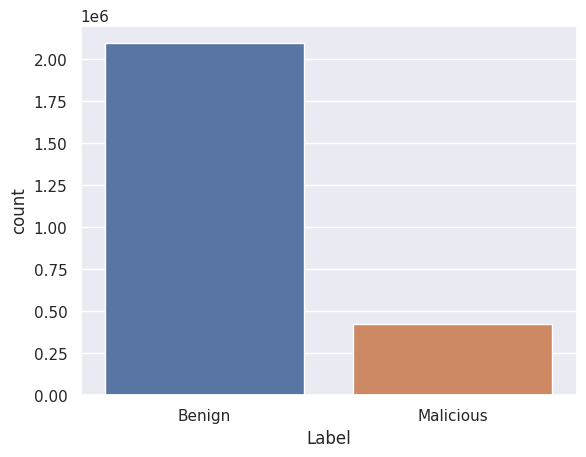

In [ ]:
sns.countplot(data=df['Label'].apply(lambda label: 'Malicious' if label != 'BENIGN' else 'Benign').to_frame(), x='Label')

**Dados não balanceados**. Impactos:
- Dificuldade de treinar modelos supervisionados
- Dificuldade de avaliar resultados com métricas tradicionais como acurácia

### Quantidade de instâncias por tipo de ataque

Abaixo está um descritivo para os ataques do dataset:

**DoS (Denial of Service)**: Esses ataques, como "DoS Hulk", "DoS GoldenEye", "DoS Slowloris", "DoS Slowhttptest" e "DDoS" visam tornar temporariamente uma máquina ou recurso de rede indisponível, sendo diferenciados pelo protocolo e estratégia usados para causar a negação de serviço. No caso do "DDoS", várias máquinas Windows 8.1 foram usadas para enviar solicitações UDP, TCP e HTTP.

**FTP Patator" e "SSH Patator**: Usam o software Patator para adivinhar senhas por força bruta com o uso de listas de palavras.

**Web - Brute Force**: Usa força bruta em uma aplicação com listas de palavras.

**Web - Injeção de SQL**: Esse ataque explora vulnerabilidades em máquinas conectadas publicamente à Internet usando injeção SQL.

**Web - XSS (Cross-Site Scripting)**: Representa injeções de scripts em aplicativos da web, visando a execução de ações maliciosas por outros usuários do aplicativo.

**PortScan**: Realizados com a ferramenta NMap, esses ataques buscam informações sobre os serviços e portas abertas em um alvo.

**Bot**: Esse ataque tem várias possibilidades, como roubo de dados, envio de spam e acesso ao dispositivo. .

**Infiltration**: Baseado na infecção de uma máquina após um usuário abrir um arquivo malicioso.

In [ ]:
df['Label'] = df['Label'].replace({'Web Attack � Brute Force':'Brute Force', 'Web Attack � XSS':'XSS', 'Web Attack � Sql Injection':'Sql Injection'})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'DoS Hulk'),
  Text(1, 0, 'DDoS'),
  Text(2, 0, 'PortScan'),
  Text(3, 0, 'DoS GoldenEye'),
  Text(4, 0, 'FTP-Patator'),
  Text(5, 0, 'DoS slowloris'),
  Text(6, 0, 'DoS Slowhttptest'),
  Text(7, 0, 'SSH-Patator'),
  Text(8, 0, 'Bot'),
  Text(9, 0, 'Brute Force'),
  Text(10, 0, 'XSS'),
  Text(11, 0, 'Infiltration'),
  Text(12, 0, 'Sql Injection'),
  Text(13, 0, 'Heartbleed')])

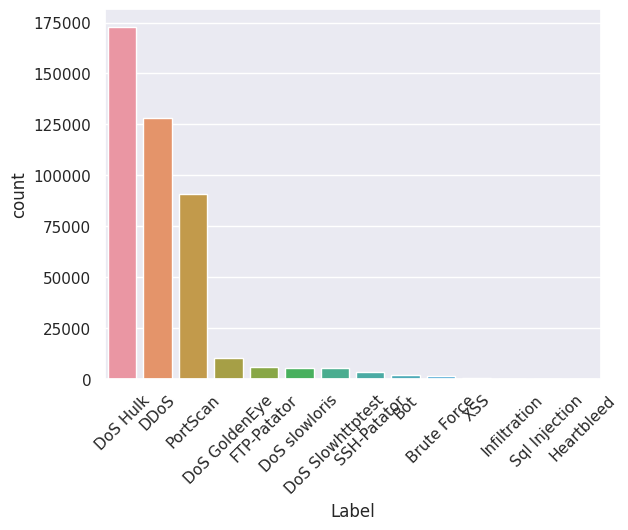

In [ ]:
sns.countplot(data=df.query('Label != "BENIGN"')[['Label']], x='Label', order = df.query('Label != "BENIGN"')['Label'].value_counts().index)
plt.xticks(rotation=45)

Ataques menos representados

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Heartbleed'),
  Text(1, 0, 'Infiltration'),
  Text(2, 0, 'Brute Force'),
  Text(3, 0, 'XSS'),
  Text(4, 0, 'Sql Injection')])

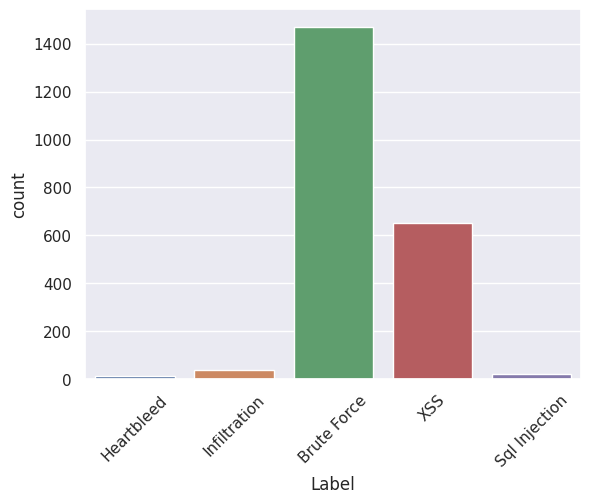

In [ ]:
N_LESS_REPRESENTED_LABELS = 5

sns.countplot(data=df[df['Label'].isin(df.groupby('Label').size().sort_values(ascending=False)[(-1)*N_LESS_REPRESENTED_LABELS:].index)], x='Label')
plt.xticks(rotation=45)

### Estatísticas dos dados

In [ ]:
interesting_cols = ['Flow Duration', 'Flow Bytes/s', 'Total Fwd Packets', 'Average Packet Size', 'SYN Flag Count']
df[interesting_cols].describe()

,Flow Duration,Flow Bytes/s,Total Fwd Packets,Average Packet Size,SYN Flag Count
count,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06,2.522009e+06
mean,1.658364e+07,2.404467e+06,1.027750e+01,2.123412e+02,4.874487e-02
std,3.522618e+07,5.254864e+07,7.942294e+02,3.454504e+02,2.153342e-01
min,-1.300000e+01,-2.610000e+08,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.080000e+02,1.194510e+02,2.000000e+00,9.000000e+00,0.000000e+00
50%,5.058700e+04,3.722028e+03,2.000000e+00,8.075000e+01,0.000000e+00
75%,5.330376e+06,1.079162e+05,6.000000e+00,1.796923e+02,0.000000e+00
max,1.200000e+08,2.071000e+09,2.197590e+05,3.893333e+03,1.000000e+00


# Dividindo dados nos conjuntos de treino, validação e teste

**Conjunto de treino**

Para a detecção de anomalias, vamos usar somente os dados que representam o tráfego benigno para o conjunto de treino. Dessa forma, os algoritmos de clustering vão ser capazes de identificar padrões e desvios em relação ao comportamento normal (benigno) dos dados.

**Conjuntos de validação e teste**

Porém, devem ser incluídos dados que representam o tráfego maliciosos nos conjuntos de validação e teste. Esses dados maliciosos no conjunto de validação são importantes para que possamos definir um *threshold* para que seja possível detectar anomalias. Além disso, os dados maliciosos também precisam ser incluídos no conjunto de teste para que possamos avaliar o desempenho do nosso modelo.

In [ ]:
df_train = df.query('Label == "BENIGN"').sample(frac=0.6, random_state=RANDOM_SEED)
df_val_test = df.drop(df_train.index)

df_train = df_train.reset_index(drop=True)
df_val_test = df_val_test.reset_index(drop=True)

X_train = df_train.drop('Label', axis='columns')

In [ ]:
X_val, X_test, classes_val, classes_test = train_test_split(df_val_test.drop('Label', axis='columns'), df_val_test['Label'], test_size=0.65, stratify=df_val_test['Label'], random_state=RANDOM_SEED)

X_val, X_test = X_val.reset_index(drop=True), X_test.reset_index(drop=True)
classes_val, classes_test =  classes_val.reset_index(drop=True), classes_test.reset_index(drop=True)

y_val, y_test = classes_val.apply(lambda c: 0 if c == 'BENIGN' else 1), classes_test.apply(lambda c: 0 if c == 'BENIGN' else 1)

In [ ]:
del df_train, df_val_test

# Analisando correlação entre features

**Por que remover features?**

Vamos descartar features com alta correlação evitando passar informações redundantes ao modelo. Dessa forma, conseguiremos obter um modelo mais simples e com menor custo computacional.

In [ ]:
def get_highly_correlated_features(correlation_matrix, threshold):
  correlated_pairs = []
  for i in range(len(correlation_matrix.columns)):
    for j in range(i):
      if abs(correlation_matrix.iloc[i, j]) > threshold:
        pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
        coefficient = correlation_matrix.iloc[i, j]
        correlated_pairs.append((pair, coefficient))
  return sorted(correlated_pairs, key= lambda pair: pair[1], reverse=True)


In [ ]:
corr_matrix = X_train.corr().abs()
correlation_list = get_highly_correlated_features(corr_matrix, 0.95)

In [ ]:
correlation_list[:10]

[(('SYN Flag Count', 'Fwd PSH Flags'), 1.0),
 (('CWE Flag Count', 'Fwd URG Flags'), 1.0),
 (('Avg Fwd Segment Size', 'Fwd Packet Length Mean'), 1.0),
 (('Fwd Header Length.1', 'Fwd Header Length'), 1.0),
 (('Subflow Fwd Packets', 'Total Fwd Packets'), 1.0),
 (('Subflow Fwd Bytes', 'Total Length of Fwd Packets'), 1.0),
 (('Subflow Bwd Packets', 'Total Backward Packets'), 1.0),
 (('Avg Bwd Segment Size', 'Bwd Packet Length Mean'), 0.9999999999999991),
 (('Subflow Bwd Bytes', 'Total Length of Bwd Packets'), 0.9999998773938246),
 (('ECE Flag Count', 'RST Flag Count'), 0.9987940568433553)]

In [ ]:
# Drop high correlated features in correlation list

f2drop = []
for feature_pair, _ in correlation_list:
  if feature_pair[0] not in f2drop and feature_pair[1] not in f2drop:
    f2drop.append(feature_pair[1])

In [ ]:
f2drop

['Fwd PSH Flags',
 'Fwd URG Flags',
 'Fwd Packet Length Mean',
 'Fwd Header Length',
 'Total Fwd Packets',
 'Total Length of Fwd Packets',
 'Total Backward Packets',
 'Bwd Packet Length Mean',
 'Total Length of Bwd Packets',
 'RST Flag Count',
 'Subflow Fwd Packets',
 'Flow Duration',
 'Packet Length Mean',
 'Flow IAT Max',
 'Subflow Bwd Packets',
 'Idle Mean',
 'Fwd IAT Total',
 'Fwd Packet Length Max',
 'Max Packet Length',
 'Bwd IAT Max',
 'Bwd IAT Mean',
 'Fwd IAT Max',
 'Fwd IAT Mean',
 'Idle Max']

A feature "Destination Port", também não fornece muita contribuição devido que a mesma está codificada com valores inteiros, indicando uma relação de grandeza, como 44720 > 80, que não apresenta sentido semântico quando se trata da porta de destino de um fluxo de rede.

In [ ]:
f2drop = f2drop + ['Destination Port']

In [ ]:
X_train = X_train.drop(f2drop, axis='columns')
X_val = X_val.drop(f2drop, axis='columns')
X_test = X_test.drop(f2drop, axis='columns')

# Normalizando os dados

É importante normalizar os dados para lidar com diferentes escalas, sensibilidades a escalas e até mesmo melhorar o desempenho da convergência dos algoritmos.

Caso não seja realizada a normalização, um valor de 10000 para uma feature como "Flow Bytes/s" terá impacto similar ao modelo quanto um valor de 10000 para uma feature como "Flow Packets/s". Isso é prejudicial, pois o impacto desse valor para as duas features deve ser tratado de forma distinta, já que as mesmas têm escalas e sensibilidades também distintas.

In [ ]:
std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train)

norm_X_train = std_scaler.transform(X_train)
norm_X_val = std_scaler.transform(X_val)
norm_X_test = std_scaler.transform(X_test)

In [ ]:
del X_train, X_val, X_test

In [ ]:
random_train_indexes = np.random.choice(norm_X_train.shape[0], int(norm_X_train.shape[0]*0.02), replace=False)
norm_X_train_subset = norm_X_train[random_train_indexes,:]

In [ ]:
random_train_indexes = np.random.choice(norm_X_val.shape[0], int(norm_X_val.shape[0]*0.02), replace=False)
norm_X_val_subset = norm_X_val[random_train_indexes,:]

# Detecção de Anomalias com o KMeans

Dado um grupo de amostras de dados, o objetivo do k-means é criar um número k de clusters de modo que cada amostra de dados pertença a um dos grupos formados. O primeiro passo para a construção dos clusters é selecionar aleatoriamente k centróides, que são representações do centro de cada cluster. De maneira mais simples, se cada amostra de dados pode ser representada por um ponto, o centróide de um grupo é um ponto no centro desse grupo. Em seguida, três outras etapas são repetidas para atualizar os grupos até que seus centróides tenham estabilizado e não mudem mais de lugar:

1. A distância euclidiana é calculada entre cada centróide e todas as amostras de dados.
2. Cada amostra é atribuída ao centróide mais próximo que forma os grupos;
3. Cada centróide de cluster é atualizado através da média da distância entre as amostras de dados dentro de cada cluster.


Porém, para que o algoritmo KMeans seja utilizado, precisamos informar um número K de clusters esperados. Uma forma de obter um número de clusters que melhor se adapte ao conjunto de dados é através da métrica de **silhouette score**. Essa métrica é calculada considerando as distâncias intra cluster e inter clusters de cada amostra do conjunto de dados.

Para saber mais sobre essa métrica [clique aqui](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c)

In [ ]:
k_list = list(range(2, 21))
silhouette_score_list = []
for k in tqdm(k_list):
    model_kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    model_kmeans = model_kmeans.fit(norm_X_train_subset)
    s_score = silhouette_score(norm_X_train_subset, model_kmeans.predict(norm_X_train_subset))
    silhouette_score_list.append(s_score)

  0%|          | 0/19 [00:00<?, ?it/s]

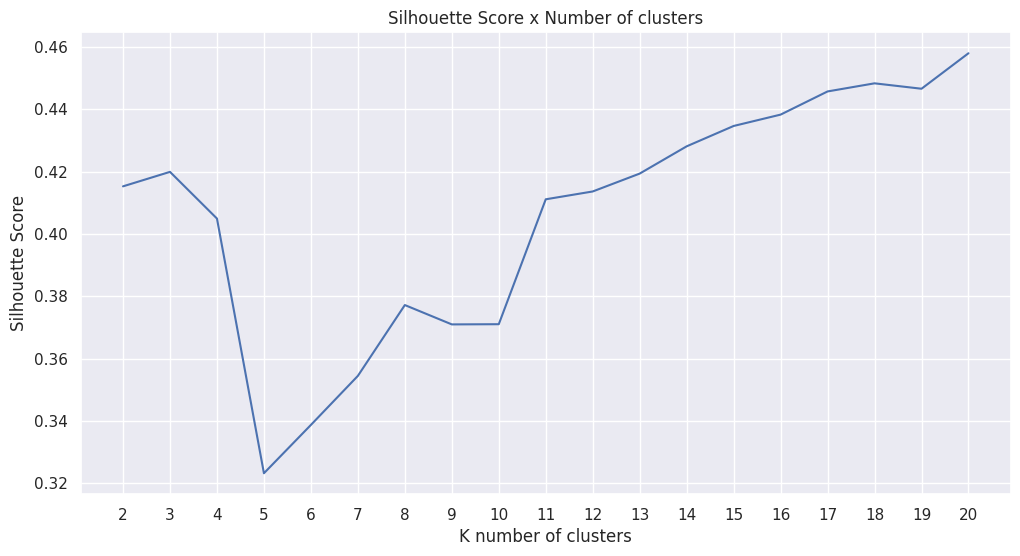

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('K number of clusters')
ax.set_ylabel('Silhouette Score')
ax.set_xticks(k_list)
ax.set_title('Silhouette Score x Number of clusters')
ax.plot(k_list, silhouette_score_list)

In [ ]:
K_CLUSTERS = 20

In [ ]:
model_kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=RANDOM_SEED, n_init=10)
model_kmeans = model_kmeans.fit(norm_X_train)

In [ ]:
def plot_pca(X, model_kmeans=None, print_centroids = False):
  pca = PCA(n_components=2, random_state=RANDOM_SEED)
  X_pca = pca.fit_transform(X)

  fig, ax = plt.subplots(figsize=(14, 6))
  ax.set_title('PCA Analysis')

  if print_centroids and model_kmeans is not None:
    cluster_centers_principal_components = pca.transform(model_kmeans.cluster_centers_)
    num_clusters = cluster_centers_principal_components.shape[0]

    X_clusters = model_kmeans.predict(X)

    print(X_clusters)

    # For each cluster, plot their respective X data instances
    for cluster in range(num_clusters):
      indexes = np.where(X_clusters == cluster)
      ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')

    # For each cluster centroid, plot the centroid
    for i, cluster_center_pc in enumerate(cluster_centers_principal_components):
      ax.scatter(cluster_center_pc[0], cluster_center_pc[1], c='black', s=8, marker='x')
      ax.annotate(f'Cluster#{i}', (cluster_center_pc[0], cluster_center_pc[1]), size=10)
    ax.legend()

  else:
    ax.scatter(X_pca[:,0], X_pca[:,1], s=1)

[8 0 9 ... 8 3 3]


<ipython-input-79-909d535b76c6>:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_pca[indexes, 0], X_pca[indexes, 1], s=1, c=plt.cm.tab20(cluster), label=f'Cluster#{cluster}')
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


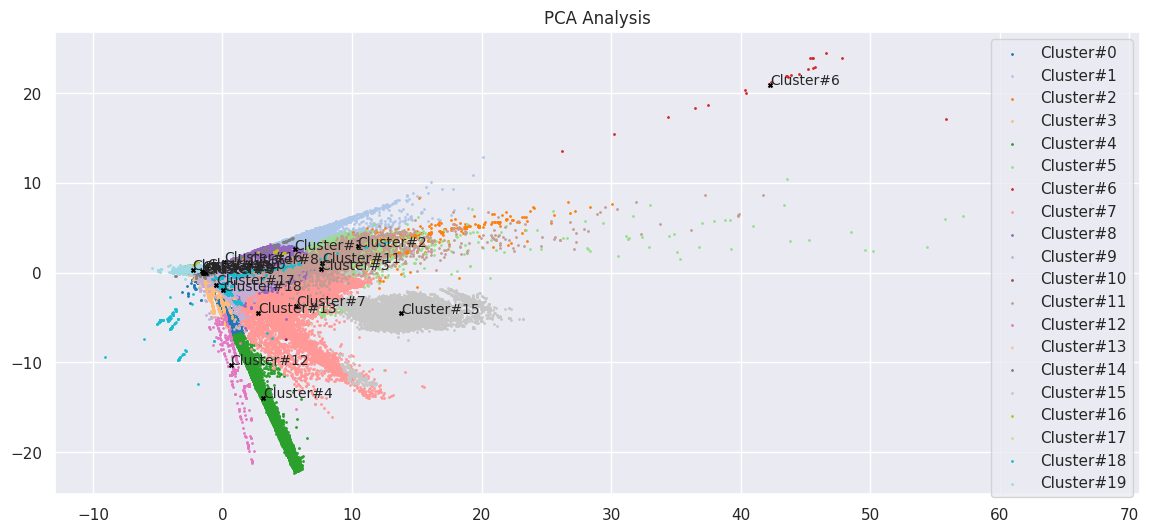

In [ ]:
plot_pca(norm_X_train, model_kmeans, print_centroids=True)

# Detecção de Anomalias com DBSCAN

  O modelo DBSCAN ("Density-Based Spatial Clustering of Applications with Noise") possui uma abordagem de clusterização baseada na densidade. Basicamente, a densidade de pontos em determinada região é responsável pela formação dos clusters.

  Os parâmetros para esse modelo são:
  * **Eps**: Raio máximo em que dois pontos podem estar para serem considerados do mesmo cluster.
  * **MinPts**: Número mínimo de pontos em uma região necessários para garantir uma densidade desejada.

O funcionamento desse modelo pode ser descrito através dos seguintes passos:

  *   Escolher um ponto arbitrário
  *   Classificá-lo como Núcleo, Borda ou Ruído
  *   Se o ponto do momento é um Núcleo, todos os pontos à sua volta com um raio  
      de distância Eps formam um cluster. Reclassificações podem ocorrer.
  *   Depois de classificar todos os pontos da região do núcleo, volta-se à      etapa   1.
  * O algoritmo termina quando todos os pontos tiverem sido classificados corretamente.

Quanto a borda, núcleo e ruído:

* **Núcleo**: Um ponto é considerado núcleo quando possui MinPts pontos ou mais dentro de um raio de Eps de distância.
* **Bordas**: Um ponto é considerado borda quando não possui MinPts dentro de um raio Eps de distância, porém está inserido dentro de um raio Eps de um outro ponto no qual é núcleo.
* **Ruídos(ou Outliers)**: Um ponto é considerado um ruído quando este não está presente no raio Eps de um núcleo e nem possui MinPts dentro do seu raio Eps.





Otimização de hiperparâmetro (Infelizmente não consigo usar um intervalo maior, pois excede o limite da memória RAM do collab)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

param_grid = {
    'eps': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
    'min_samples': [2,4,6,8,10,12]
}

best_score = -1
best_params = None

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(**params)
    labels = dbscan.fit_predict(norm_X_train_subset)

    score = silhouette_score(norm_X_train_subset, labels)

    if score > best_score:
        best_score = score
        best_params = params

print("Melhores Parâmetros:", best_params)
print("Melhor Silhouette Score:", best_score)

Melhores Parâmetros: {'eps': 2.0, 'min_samples': 10}
Melhor Silhouette Score: 0.35846268063976994


vou construir um objeto para o modelo do DBSCAN


In [ ]:
dbscan = DBSCAN(min_samples=10, eps=2.0)
dbscan_labels = dbscan.fit_predict(norm_X_train_subset)

O código a seguir imprimi o número de clusters e ruídos



In [ ]:
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Number of Clusters : ', n_clusters_)
print('Number of Outliers : ', n_noise_)


Number of Clusters :  34
Number of Outliers :  1379


Irei utilizar o PCA para apresentar uma representação gráficas dos clusters.
Obs: os pontos de cor preta são ruídos.

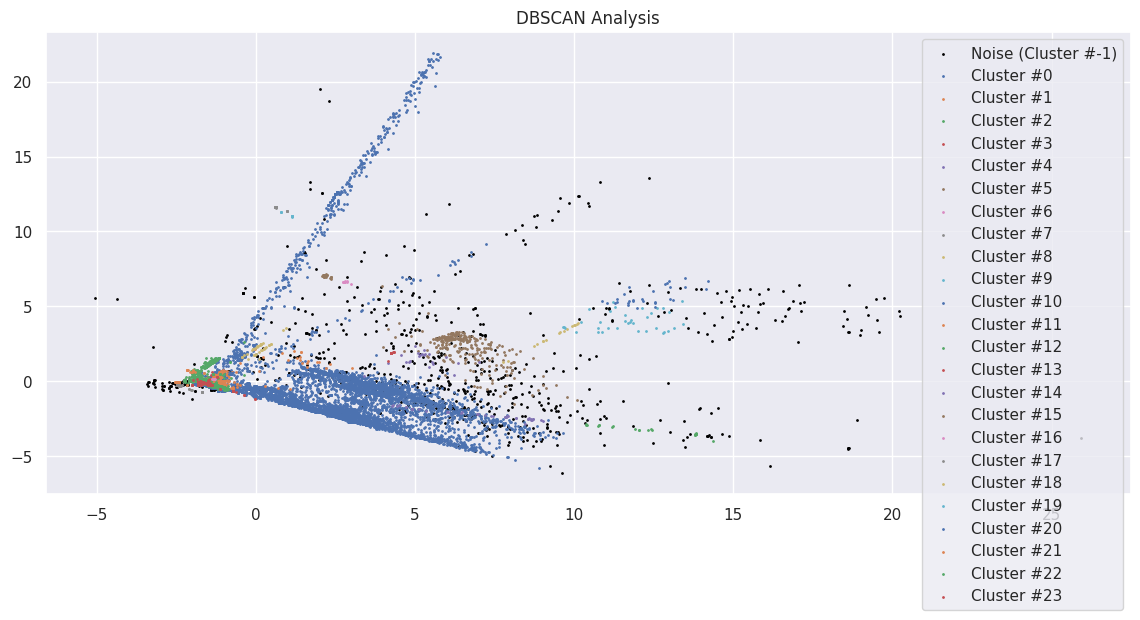

In [ ]:

def plot_dbscan(X, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(X)

    pca = PCA(n_components=2, random_state=RANDOM_SEED)
    X_pca = pca.fit_transform(X)

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.set_title('DBSCAN Analysis')

    unique_labels = np.unique(dbscan_labels)

    for label in unique_labels:
        if label == -1:

            noise_mask = (dbscan_labels == label)
            ax.scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1], s=1, c='black', label=f'Noise (Cluster #{label})')
        else:
            cluster_mask = (dbscan_labels == label)
            ax.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], s=1, label=f'Cluster #{label}')

    ax.legend()

plot_dbscan(norm_X_train_subset, eps=3, min_samples=10)
plt.show()


# Definindo um threshold e avaliando resultados

Função que define a matriz de confusão

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

Calculando a **taxa de verdadeiros positivo**, também é conhecida como "Sensibilidade", "Recall" ou "Taxa de Positivos Verdadeiros", por ataque.

In [ ]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})
  total_per_label = aux_df['Label'].value_counts().to_dict()
  correct_predictions_per_label = aux_df.query('Label != "BENIGN" and prediction == True').groupby('Label').size().to_dict()
  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 'BENIGN':
      continue
    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

Calculando a **Curva ROC**

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

Calculando métricas gerais

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

Gerando uma curva ROC para o DBScan


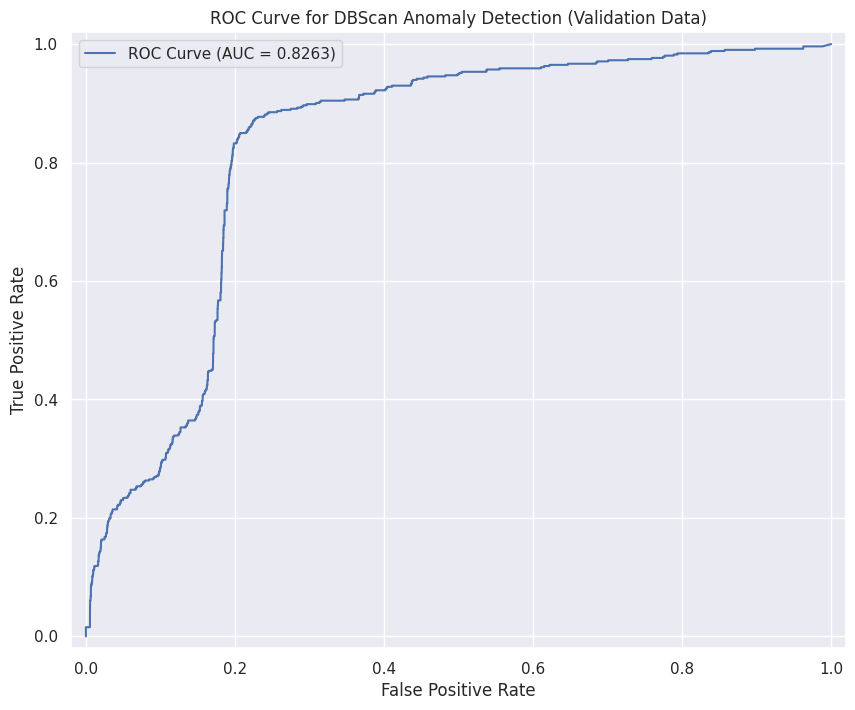

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.pairwise import pairwise_distances

dbscan_train = DBSCAN(min_samples=10, eps=3)
dbscan_labels_train = dbscan_train.fit_predict(norm_X_train_subset)

val_distances_to_nearest_cluster = np.min(pairwise_distances(norm_X_val_subset, dbscan_train.components_), axis=1)

y_true_val = np.zeros(len(norm_X_val_subset))
y_true_val[dbscan_labels_val == -1] = 1

y_score_val = val_distances_to_nearest_cluster

fpr_val, tpr_val, thresholds_val = roc_curve(y_true_val, y_score_val)
aucroc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(10, 8))
plt.plot(fpr_val, tpr_val, label=f'ROC Curve (AUC = {aucroc_val:.4f})')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for DBScan Anomaly Detection (Validation Data)')
plt.legend()
plt.show()


Curva ROC para o K-means

In [ ]:
val_centroids_distances = model_kmeans.transform(norm_X_val)
val_anomaly_scores = np.min(val_centroids_distances, axis=1)

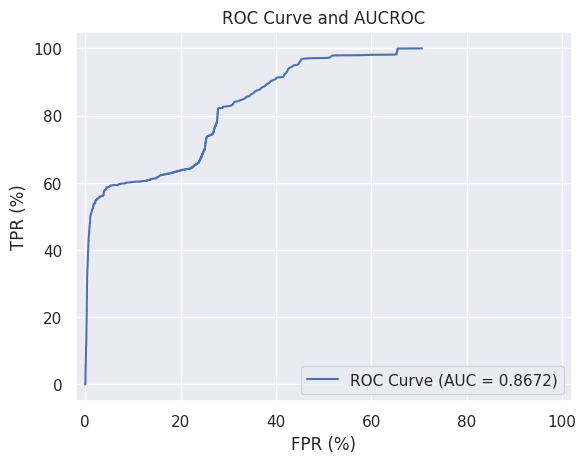

In [ ]:
plot_roc_curve(y_val, val_anomaly_scores)

# Explicação

O DBScam se mostrou mais eficiente na detecção de ciberataques em relação ao K-means. Isso porque a forma como o DBScam gera os seus cluster está relacionado com a densidade e com uma métrica de ditância. Como percebemos na base de dados, os dados relacionados a ciberataques são menos recorrentes, logo ocupando áreas mais distantes e de menor densidade o que faz com que sejam  facilmente detectadas pelo DBScam. Além disso, como o DBScam não tem um número determinado de clusters, como o K-means, ele consegue se enquadrar melhor aos dados. Isso pode ser visto na Principal Component Analysis (PCA) presente no collab. Analisando a curva ROC, percebemos que ambos reconhecem os verdadeiros positivos de formas semelhantes e tem limiares parecidos para diferenciar dados benignos de malignos.